#### In order to measure the efficacy of the attention-intervention system, we are going to use the data aquired during the test runs.

#### There were 3 groups of people tested:
    - goal-oriented and text based nudging      [T]
    - goal-irrelevant (funny) video nudging     [M]
    - control group without intervention        [C]

#### The measurements include these metrics:
    - time variable                                 (continuous float)
    - attention score                               (float)
    - blinking, head position and reading           (boolean)
    - nudge                                         (boolean)


#### In our case, we might argue that the system was effective if:

    - Attentive state percentages                   [T | M] > [C]
    - Inattentive state durations                   [T | M] < [C]
    - Nominal average attentive timewindows         [T | M] > [C]
    - Reading progress                              [T | M] > [C]
    - & comprehension                               [T | M] > [C]
    - feedback & experience analysis                [T | M] > [C]


In [101]:
import pandas as pd
from pprint import pprint
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Patch
import json

### Reading in the saved data files

In [102]:
def parse_collected_data(folder_path):
    data_dict = {}
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            name = f"{subfolder.split("_")[1]}_{subfolder.split("_")[2]}"
            data_dict[name] = {}
            for file in os.listdir(subfolder_path):
                if file.startswith('attn_') and file.endswith('2.csv'):
                    data_dict[name]['attn2'] = pd.read_csv(f"./collected_data/{subfolder}/{file}")
                elif file.startswith('attn_') and file.endswith('.csv'):
                    data_dict[name]['attn1'] = pd.read_csv(f"./collected_data/{subfolder}/{file}")
                elif file.startswith('nudge_') and file.endswith('.txt'):
                    continue
                    data_dict[name]['nudge'] = pd.read_csv(f"./collected_data/{subfolder}/{file}")
                elif file.startswith('question') and file.endswith('.csv'):
                    data_dict[name]['question'] = pd.read_csv(f"./collected_data/{subfolder}/{file}")
                elif file.startswith('pre') and file.endswith('.json'):
                    with open(f"./collected_data/{subfolder}/{file}", 'r') as f:
                        data_dict[name]["pre"] = json.load(f)
                elif file.startswith('post') and file.endswith('.json'):
                    with open(f"./collected_data/{subfolder}/{file}", 'r') as f:
                        data_dict[name]["post"] = json.load(f)
            try:
                data_dict[name]['full_attn'] = data_dict[name]['attn1'].join(data_dict[name]['attn2'])
                data_dict[name]['full_attn'] = data_dict[name]['full_attn'][:-10]
                data_dict[name]['full_attn']['nudge'] = data_dict[name]['full_attn']['nudge'].astype(bool)
                data_dict[name].pop("attn1")
                data_dict[name].pop("attn2")
            except:
                data_dict[name]['full_attn'] = data_dict[name].pop("attn1")
    return data_dict

# Example usage
collected_data_path = './collected_data'
parsed_data = parse_collected_data(collected_data_path)


#### Some exploration...

In [103]:
parsed_data["A-H_1"]["full_attn"].iloc[3000:]

,Unnamed: 0,time,attention_levels,is_looking_at_screen_scores,is_blinking_scores,is_reading_scores,attention_scores,timestamp,nudge,attn
3000,3000,1.749316e+09,1,1,False,1,0.4378,1.749316e+09,True,0.4378
3001,3001,1.749316e+09,1,1,False,1,0.4400,1.749316e+09,True,0.4400
3002,3002,1.749316e+09,1,1,False,1,0.4422,1.749316e+09,True,0.4422
3003,3003,1.749316e+09,1,1,False,1,0.4444,1.749316e+09,True,0.4444
3004,3004,1.749316e+09,1,1,False,1,0.4467,1.749316e+09,True,0.4467
...,...,...,...,...,...,...,...,...,...,...
51365,51365,1.749317e+09,1,1,False,1,0.2778,1.749317e+09,False,0.2778
51366,51366,1.749317e+09,1,1,False,1,0.2800,1.749317e+09,False,0.2800
51367,51367,1.749317e+09,1,1,False,1,0.2822,1.749317e+09,False,0.2822
51368,51368,1.749317e+09,1,1,False,1,0.2844,1.749317e+09,False,0.2844


In [104]:
parsed_data["A-H_1"]['full_attn'].keys()

Index(['Unnamed: 0', 'time', 'attention_levels', 'is_looking_at_screen_scores',
       'is_blinking_scores', 'is_reading_scores', 'attention_scores',
       'timestamp', 'nudge', 'attn'],
      dtype='object')

In [105]:
NUDGE_THRESHOLD = 0.01
for subject, data in parsed_data.items():
    if subject.endswith("3"):
        data["full_attn"]["nudge"] = data["full_attn"]["attn"] < NUDGE_THRESHOLD
    
    data["full_attn"].fillna(value=0.0, inplace=True)

    if 'nudge' in data["full_attn"].columns and 'time' in data["full_attn"].columns:
        inattentive_time = data["full_attn"].query('nudge')['time'].diff().sum()
        data["inattentive_time"] = inattentive_time

In [106]:
parsed_data["C-H_2"]["full_attn"]["nudge"]

0        False
1        False
2        False
3        False
4        False
         ...  
47461    False
47462    False
47463    False
47464    False
47465    False
Name: nudge, Length: 47466, dtype: bool

In [107]:
for subject, data in parsed_data.items():
    print(subject)
    print(data["inattentive_time"])

A-H_1
1625.7252128124237
A-H_3
1875.5696682929993
C-H_2
1517.6977467536926
D-H_2
1704.581363916397
G-B_3
709.9283502101898
J-G_3
1422.9731051921844
M-C_2
1588.0410888195038
M-K_1
796.4807796478271
S-S_1
1856.9781682491302
Z-A_3
550.3202276229858


## Generating the attention lineplots

In [108]:
subjects = list(parsed_data.keys())

output_dir = "results/attention_plots_secs"
os.makedirs(output_dir, exist_ok=True)


for subject in subjects:
    filename = os.path.join(output_dir, f"{subject}_attention.png")
    if os.path.exists(filename):
        print(f"Skipping {subject}: file already exists.")
        continue
    # Check if 'attn' column exists in the dataframe
    if 'attn' in parsed_data[subject]["full_attn"].columns:
        plt.figure(figsize=(10, 6))
        attn_data = parsed_data[subject]["full_attn"]['attn']
        nudge_data = parsed_data[subject]["full_attn"]['nudge']
        
        # Plot attention levels
        plt.plot(attn_data, label='Attention Levels')
        
        # Highlight sections where 'nudge' is True
        for i in range(len(nudge_data)):
            if nudge_data[i]:
                plt.axvspan(i, i+1, color=(252/255, 187/255, 198/255), alpha=0.5)
        
        plt.ylim(-1.2, 1.2)
        plt.title(f'Attention Levels for {subject}')
        plt.xlabel('Index')
        plt.ylabel('Attention Level')
        plt.legend()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        print(f"No 'attn' column found for {subject}")


Skipping A-H_1: file already exists.
Skipping A-H_3: file already exists.
Skipping C-H_2: file already exists.
Skipping D-H_2: file already exists.
Skipping G-B_3: file already exists.
Skipping J-G_3: file already exists.
Skipping M-C_2: file already exists.
Skipping M-K_1: file already exists.
Skipping S-S_1: file already exists.
Skipping Z-A_3: file already exists.


### Attentive state percentages

between text-based and control, and video-based and control, there is a significant difference in the percentage of time spent in attentive state, i.e. the user has spent on (within group) average more time percentagewise in the attentive state than in control group average

> example: <br>
> a text-based user spent on average 10% of the time in inattentive state<br>
> a video-based user spent on average 15% of the time in inattentive state<br>
> a control user spent 40% of the time in inattentive state<br>

In [109]:

# Initialize dictionaries to store individual and group attentiveness percentages
individual_attentiveness = {}
group_attentiveness = defaultdict(list)

# Iterate over each subject in the parsed data
for subject, data in parsed_data.items():
    full_attn = data["full_attn"]
    
    # Calculate total time span of the experiment
    total_time = full_attn['time'].iloc[-1] - full_attn['time'].iloc[0]
    
    # Calculate attentive time by summing time differences where attention score is above a threshold
    attentive_time = 0
    for i in range(1, len(full_attn)):
        if full_attn['attn'].iloc[i] > 0:  # Assuming attention score > 0 indicates attentiveness
            attentive_time += full_attn['time'].iloc[i] - full_attn['time'].iloc[i-1]
    
    # Calculate percentage of time spent in attentive state
    attentiveness_percentage = (attentive_time / total_time) * 100
    individual_attentiveness[subject] = round(attentiveness_percentage, 2)
    
    # Determine group based on subject identifier and store the percentage
    if subject.endswith("1"):
        group_attentiveness['text_based'].append(attentiveness_percentage)
    elif subject.endswith("2"):
        group_attentiveness['video_based'].append(attentiveness_percentage)
    elif subject.endswith("3"):
        group_attentiveness['control'].append(attentiveness_percentage)

# Calculate average attentiveness percentage for each group
average_group_attentiveness = {group: round(sum(percentages) / len(percentages), 2) for group, percentages in group_attentiveness.items()}



### Inattentive state durations

between text-based and control, and video-based and control, there is a significant difference in the average length of the time spent in an inattentive state, i.e. the user "got out of" the inattentive state much quicker if nudged in any way than if not.

> example: <br>
> a text-based user's average inattentive state lasted 5 seconds<br>
> a video-based user's average inattentive state lasted 7 seconds<br>
> a control user's average inattentive state lasted 20 seconds<br>

In [110]:
# Initialize dictionaries to store individual and group inattentive state durations
individual_inattentive_durations = {}
group_inattentive_durations = defaultdict(list)

# Iterate over each subject in the parsed data
for subject, data in parsed_data.items():
    full_attn = data["full_attn"]
    
    # Initialize variables to calculate inattentive state durations
    inattentive_durations = []
    start_time = None
    
    # Iterate over the data to find inattentive periods
    for i in range(len(full_attn)):
        if full_attn['nudge'].iloc[i] and start_time is None:
            start_time = full_attn['time'].iloc[i]
        elif not full_attn['nudge'].iloc[i] and start_time is not None:
            end_time = full_attn['time'].iloc[i]
            inattentive_durations.append(end_time - start_time)
            start_time = None
    
    # Calculate average inattentive duration for the subject
    if inattentive_durations:
        average_inattentive_duration = round(sum(inattentive_durations) / len(inattentive_durations), 2)
    else:
        average_inattentive_duration = 0
    
    individual_inattentive_durations[subject] = average_inattentive_duration
    
    # Determine group based on subject identifier and store the average duration
    if subject.endswith("1"):
        group_inattentive_durations['text_based'].append(average_inattentive_duration)
    elif subject.endswith("2"):
        group_inattentive_durations['video_based'].append(average_inattentive_duration)
    elif subject.endswith("3"):
        group_inattentive_durations['control'].append(average_inattentive_duration)

# Calculate average inattentive duration for each group
average_group_inattentive_durations = {group: round(sum(durations) / len(durations), 2) for group, durations in group_inattentive_durations.items()}



### Nominal average attentive timewindows

the nominal average attentive timewindow after each nudge ended on average is significantly larger compared to the average attentive time following hypothetical nudges in the control group — where the system detected attention drops but did not show any actual intervention.

>example: <br>
>a text-based user spent on average 5 minutes in the attentive state after the nudge has been shown<br>
>a video-based user spent on average 3 minutes in the attentive state after the nudge has been shown<br>
>a control user spent on average just 1 minute in the attentive state after the system would have shown the nudge (but didn't as it is the control group)<br>

In [111]:
# Calculate the average nominal time spent after interventions for each user
individual_attentive_durations = {}

for subject, data in parsed_data.items():
    full_attn = data["full_attn"]
    
    # Initialize variables to calculate attentive state durations
    attentive_durations = []
    start_time = None
    
    # Iterate over the data to find attentive periods after nudge
    for i in range(1, len(full_attn)):
        if full_attn['nudge'].iloc[i-1] and not full_attn['nudge'].iloc[i]:
            start_time = full_attn['time'].iloc[i]
        elif not full_attn['nudge'].iloc[i-1] and full_attn['nudge'].iloc[i] and start_time is not None:
            end_time = full_attn['time'].iloc[i]
            attentive_durations.append(end_time - start_time)
            start_time = None
    
    # Calculate average attentive duration for the subject
    if attentive_durations:
        average_attentive_duration = round(sum(attentive_durations) / len(attentive_durations), 2)
    else:
        average_attentive_duration = 0
    
    individual_attentive_durations[subject] = average_attentive_duration

# Calculate average attentive duration for each group
group_attentive_durations = defaultdict(list)
for subject, duration in individual_attentive_durations.items():
    if subject.endswith("1"):
        group_attentive_durations['text_based'].append(duration)
    elif subject.endswith("2"):
        group_attentive_durations['video_based'].append(duration)
    elif subject.endswith("3"):
        group_attentive_durations['control'].append(duration)

average_group_attentive_durations = {group: round(sum(durations) / len(durations), 2) for group, durations in group_attentive_durations.items()}


### Reading progress & comprehension

the % correctness of the reading questions are higher among the nudging group than the control

>example: <br>
>a text-based user has achieved on average a score of 85% on the reading tasks <br>
>a video-based user has achieved on average a score of 70% on the reading tasks <br>
>a control user has achieved on average a score of 50% on the reading tasks <br>

the amount of text consumed in the same period of time is higher among the nudging groups than the control group

>example: <br>
>a text-based user has read on average 30 pages in the span of 30 minutes <br>
>a video-based user has read on average 26 pages in the span of 30 minutes <br>
>a control user has read on average 20 pages in the span of 30 minutes <br>

In [112]:
individual_reading_scores = {}

for subject in parsed_data:
    data = parsed_data[subject]["question"]
    reading_length = len(data[data["correct"] > -1])
    correct_answers = len(data[data["correct"] == 1])
    incorrect_answers = len(data[data["correct"] == 0])
    individual_reading_scores[subject] = {
        "reading_len": round(reading_length / len(data) * 100, 2),
        "reading_correctness": round(correct_answers / reading_length * 100, 2)
    }

individual_reading_len = {subject: individual_reading_scores[subject]["reading_len"] for subject in individual_reading_scores}
individual_reading_correctness = {subject: individual_reading_scores[subject]["reading_correctness"] for subject in individual_reading_scores}

group_reading_length = defaultdict(list)
group_reading_correctness = defaultdict(list)
for subject, reading in individual_reading_scores.items():
    if subject.endswith("1"):
        group_reading_length['text_based'].append(reading["reading_len"])
        group_reading_correctness['text_based'].append(reading["reading_correctness"])
    elif subject.endswith("2"):
        group_reading_length['video_based'].append(reading["reading_len"])
        group_reading_correctness['video_based'].append(reading["reading_correctness"])
    elif subject.endswith("3"):
        group_reading_length['control'].append(reading["reading_len"])
        group_reading_correctness['control'].append(reading["reading_correctness"])


average_group_reading_length = {group: round(sum(length) / len(length), 2) for group, length in group_reading_length.items()}
average_group_reading_correctness = {group: round(sum(correctness) / len(correctness), 2) for group, correctness in group_reading_correctness.items()}



In [113]:
try:

    individual_attentiveness = sorted(individual_attentiveness.items(), key=lambda x: x[1])
    average_group_attentiveness = sorted(average_group_attentiveness.items(), key=lambda x: x[1])
    individual_inattentive_durations = sorted(individual_inattentive_durations.items(), key=lambda x: x[1])
    average_group_inattentive_durations = sorted(average_group_inattentive_durations.items(), key=lambda x: x[1])
    individual_attentive_durations = sorted(individual_attentive_durations.items(), key=lambda x: x[1])
    average_group_attentive_durations = sorted(average_group_attentive_durations.items(), key=lambda x: x[1])
    individual_reading_scores = sorted(individual_reading_scores.items())
    individual_reading_len = sorted(individual_reading_len.items(), key=lambda x: x[1])
    individual_reading_correctness = sorted(individual_reading_correctness.items(), key=lambda x: x[1])
    group_reading_length = sorted(group_reading_length.items(), key=lambda x: x[1])
    group_reading_correctness = sorted(group_reading_correctness.items(), key=lambda x: x[1])
    average_group_reading_length = sorted(average_group_reading_length.items(), key=lambda x: x[1])
    average_group_reading_correctness = sorted(average_group_reading_correctness.items(), key=lambda x: x[1])

except Exception as e:
    print(e)


print("Individual Attentiveness Percentages:\t\t higher is better")
pprint(individual_attentiveness, indent=4)
print("Average Group Attentiveness Percentages:\t\t higher is better")
pprint(average_group_attentiveness, indent=4)
print("")

print("Individual Inattentive Durations:\t\t lower is better")
pprint(individual_inattentive_durations, indent=4)
print("Average Group Inattentive Durations:\t\t lower is better")
pprint(average_group_inattentive_durations, indent=4)
print("")

print("Individual Attentive Durations:\t\t higher is better")
pprint(individual_attentive_durations, indent=4)
print("Average Group Attentive Durations:")
pprint(average_group_attentive_durations, indent=4)
print("")

print("Individual Reading Scores:\t\t higher is better")
pprint(individual_reading_scores, indent=4)

print("Individual Reading Length:\t\t higher is better")
pprint(individual_reading_len)
print("Average Group Reading Length:\t\t higher is better")
pprint(average_group_reading_length, indent=4)

print("Individual Reading Correctness:\t\t higher is better")
pprint(individual_reading_correctness)
print("Average Group Reading Correctness:\t\t higher is better")
pprint(average_group_reading_correctness, indent=4)



Individual Attentiveness Percentages:		 higher is better
[   ('D-H_2', 33.84),
    ('S-S_1', 61.82),
    ('J-G_3', 71.92),
    ('A-H_3', 76.78),
    ('G-B_3', 77.66),
    ('M-C_2', 84.07),
    ('Z-A_3', 85.36),
    ('A-H_1', 90.39),
    ('C-H_2', 93.59),
    ('M-K_1', 97.55)]
Average Group Attentiveness Percentages:		 higher is better
[('video_based', 70.5), ('control', 77.93), ('text_based', 83.25)]

Individual Inattentive Durations:		 lower is better
[   ('M-C_2', 3.44),
    ('M-K_1', 4.06),
    ('D-H_2', 5.64),
    ('A-H_1', 7.22),
    ('S-S_1', 8.0),
    ('C-H_2', 11.14),
    ('A-H_3', 15.06),
    ('J-G_3', 20.68),
    ('G-B_3', 23.33),
    ('Z-A_3', 31.37)]
Average Group Inattentive Durations:		 lower is better
[('text_based', 6.43), ('video_based', 6.74), ('control', 22.61)]

Individual Attentive Durations:		 higher is better
[   ('G-B_3', 39.09),
    ('Z-A_3', 45.11),
    ('A-H_3', 49.09),
    ('J-G_3', 53.12),
    ('D-H_2', 59.7),
    ('M-C_2', 89.77),
    ('S-S_1', 115.27),
  

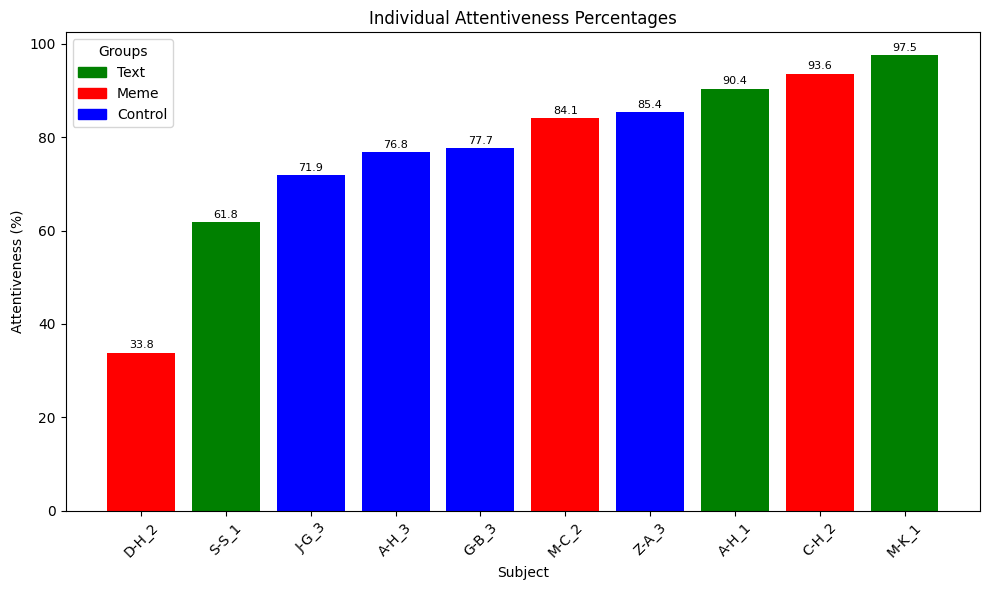

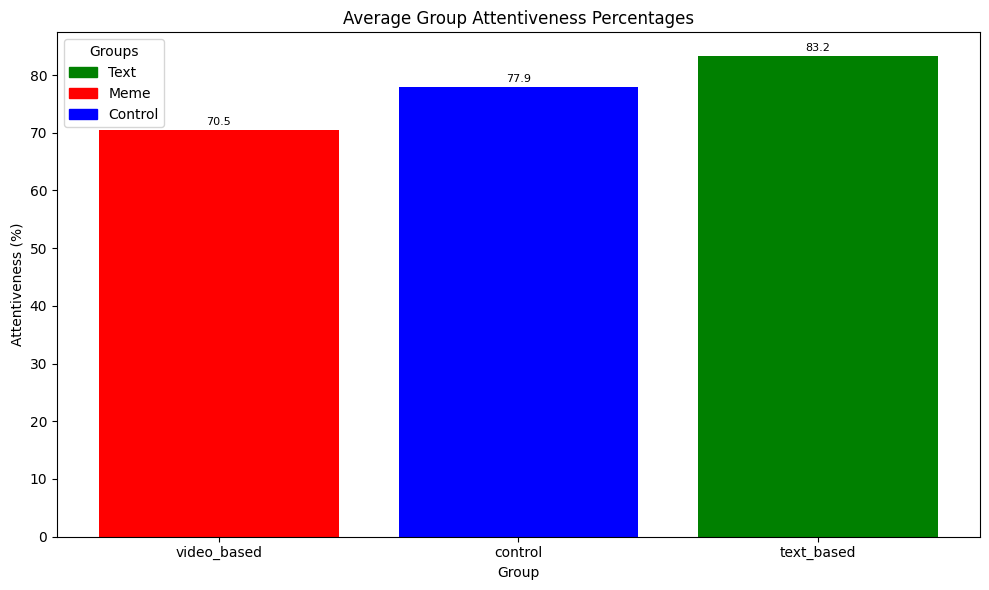

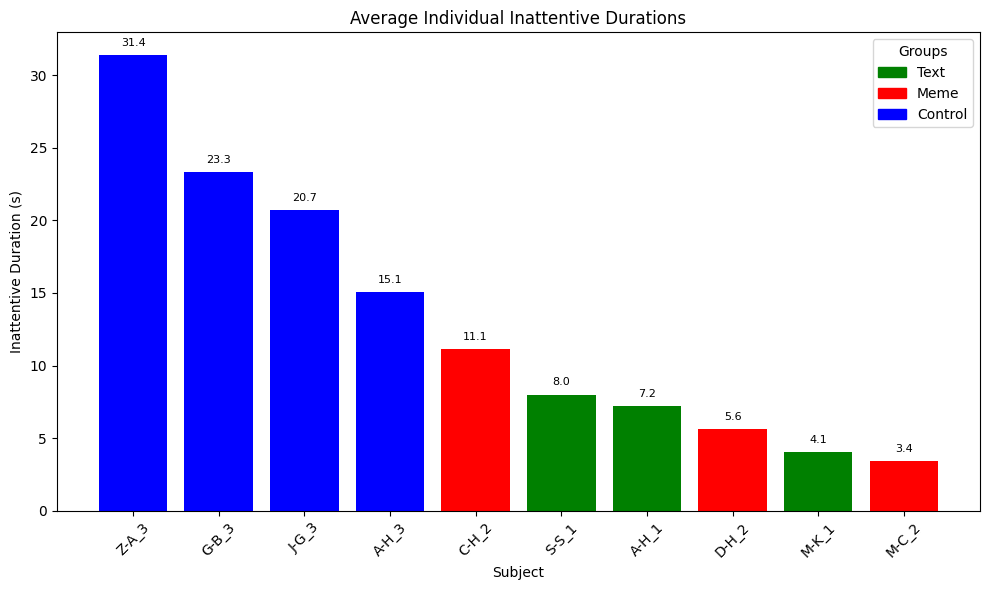

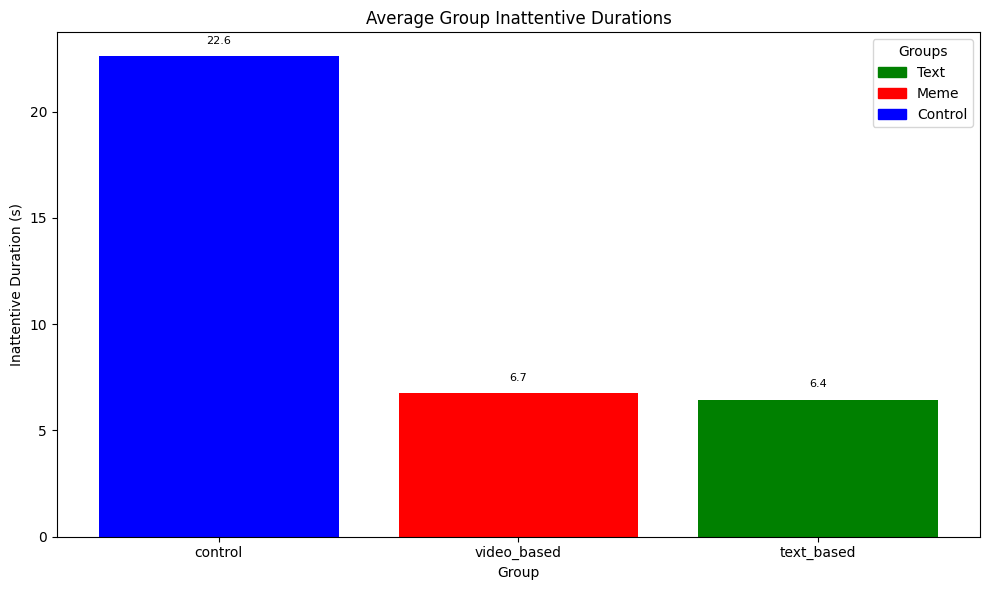

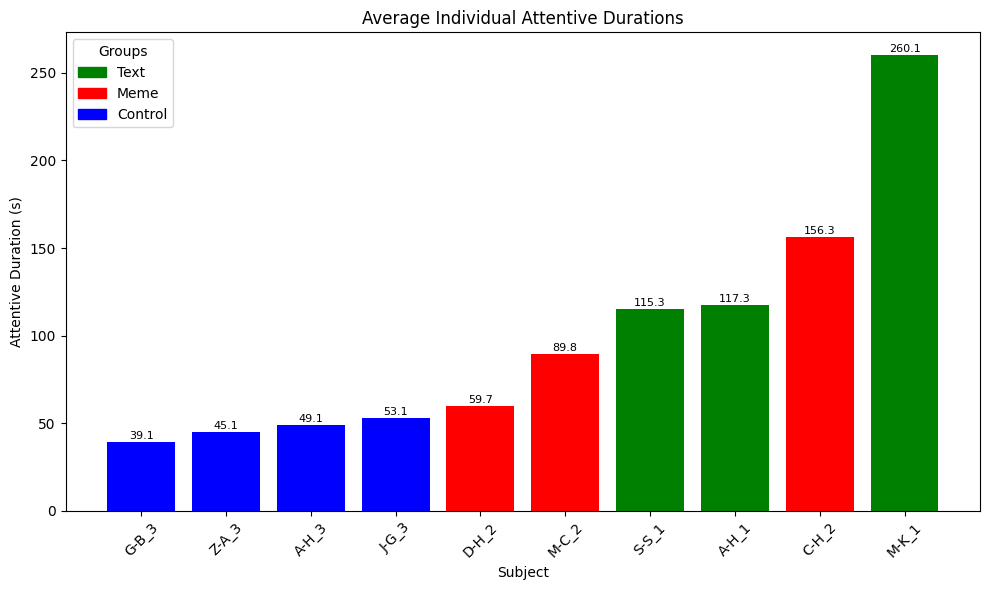

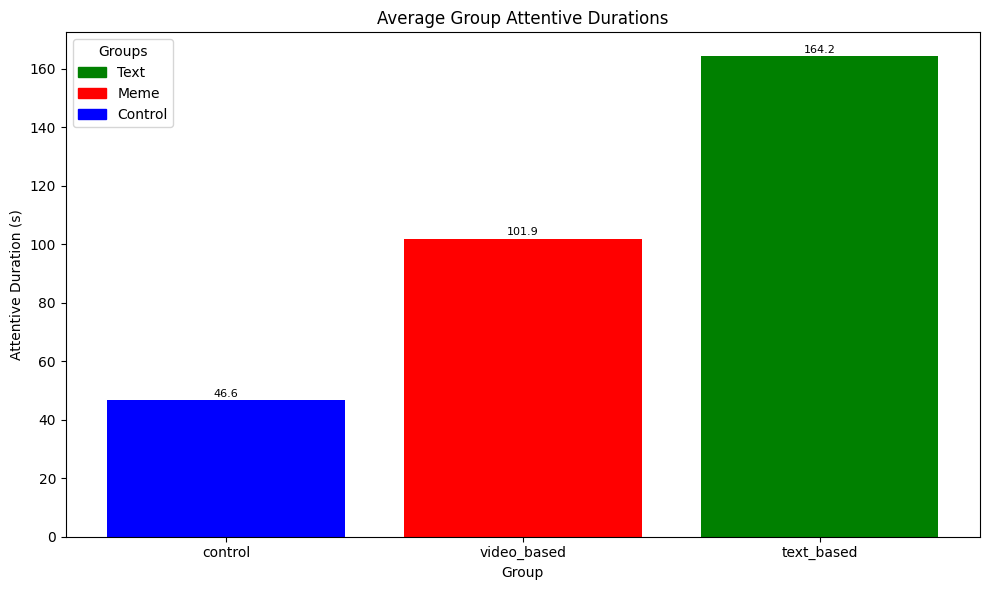

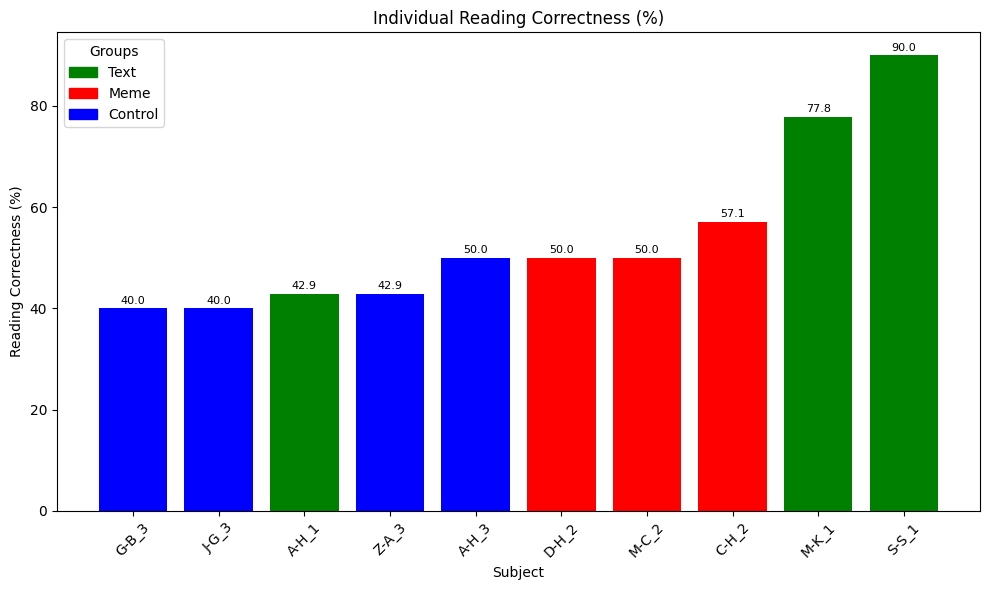

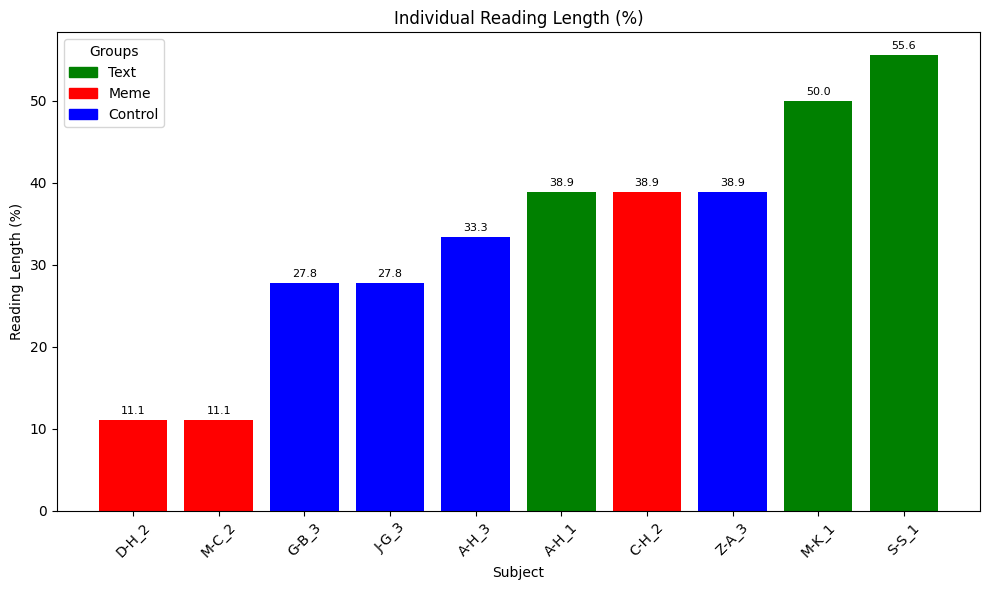

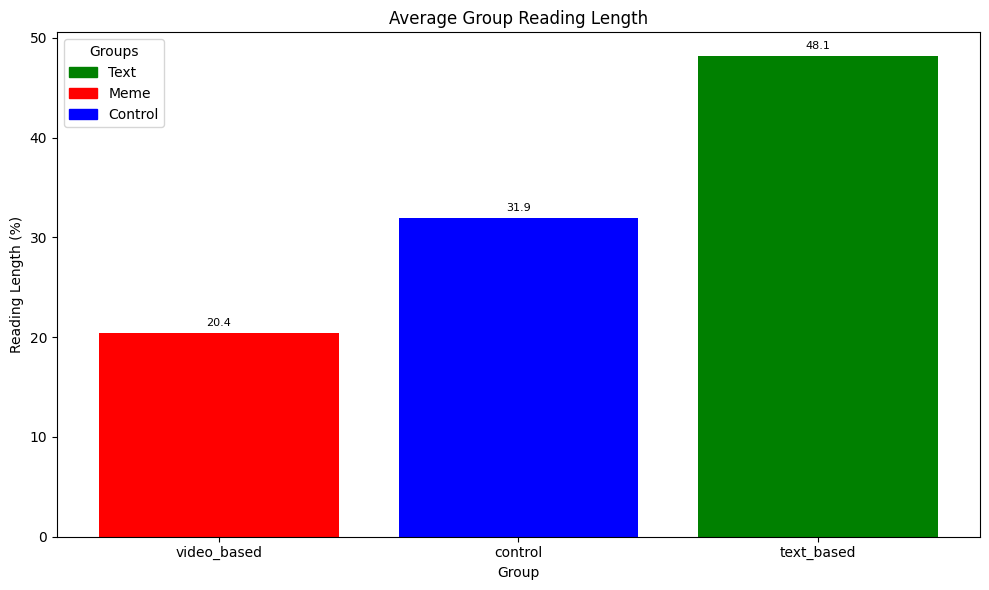

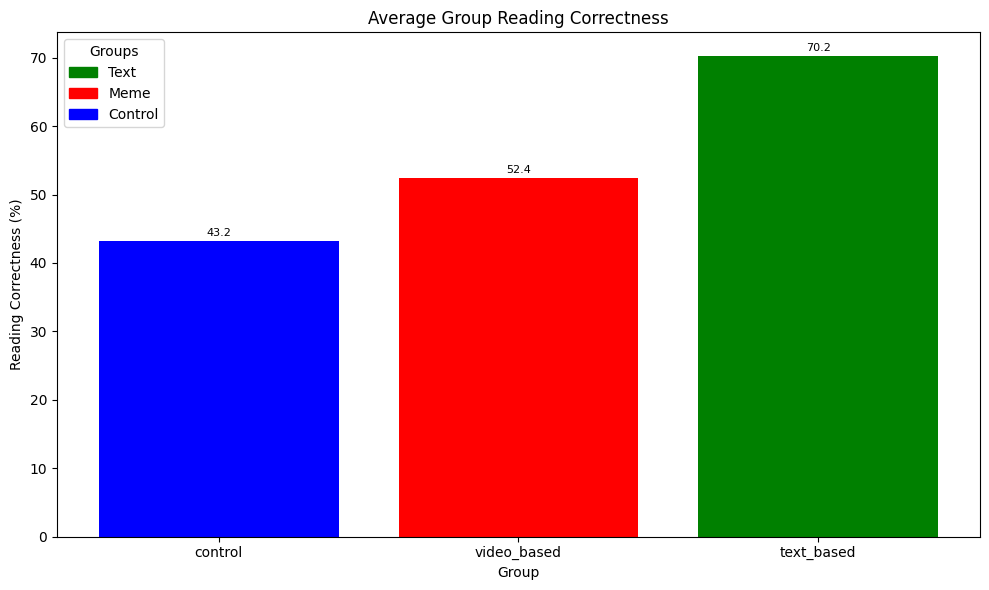

In [ ]:
import matplotlib.pyplot as plt

def assign_color(label):
    if label.endswith('1'):
        return 'green'    # text
    elif label.endswith('2'):
        return 'red'      # video
    elif label.endswith('3'):
        return 'blue'     # control
    elif label == 'text_based':
        return 'green'
    elif label == 'video_based':
        return 'red'
    elif label == 'control':
        return 'blue'
    else:
        return 'gray'

def plot_bar(data, title, xlabel, ylabel, rotation=45, figsize=(10,6), filename=None, reversed=False):
    os.makedirs("results/barplots", exist_ok=True)
    if not filename: filename = f"results/barplots/{title}.png"
    labels, values = zip(*data)
    colors = [assign_color(label) for label in labels]

    plt.figure(figsize=figsize)
    if reversed:
        labels, values, colors = labels[::-1], values[::-1], colors[::-1]
    bars = plt.bar(labels, values, color=colors)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}', ha='center', va='bottom', fontsize=8)

    legend_handles = [
        Patch(color='green', label='Text'),
        Patch(color='red', label='Meme'),
        Patch(color='blue', label='Control'),
    ]
    plt.legend(handles=legend_handles, title="Groups")

    plt.tight_layout()

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()


plot_bar(individual_attentiveness, "Individual Attentiveness Percentages", "Subject", "Attentiveness (%)")
plot_bar(average_group_attentiveness, "Average Group Attentiveness Percentages", "Group", "Attentiveness (%)", rotation=0)
plot_bar(individual_inattentive_durations, "Average Individual Inattentive Durations", "Subject", "Inattentive Duration (s)", reversed=True)
plot_bar(average_group_inattentive_durations, "Average Group Inattentive Durations", "Group", "Inattentive Duration (s)", reversed=True, rotation=0)
plot_bar(individual_attentive_durations, "Average Individual Attentive Durations", "Subject", "Attentive Duration (s)")
plot_bar(average_group_attentive_durations, "Average Group Attentive Durations", "Group", "Attentive Duration (s)", rotation=0)

plot_bar(individual_reading_correctness, "Individual Reading Correctness (%)", "Subject", "Reading Correctness (%)")

plot_bar(individual_reading_len, "Individual Reading Length (%)", "Subject", "Reading Length (%)")

plot_bar(average_group_reading_length, "Average Group Reading Length", "Group", "Reading Length (%)", rotation=0)
plot_bar(average_group_reading_correctness, "Average Group Reading Correctness", "Group", "Reading Correctness (%)", rotation=0)


In [115]:
import numpy as np
from scipy.stats import kruskal

# Flatten per participant
group1_means = [np.mean(data["full_attn"]["attn"]) for subject, data in parsed_data.items() if subject.endswith("1")]
group2_means = [np.mean(data["full_attn"]["attn"]) for subject, data in parsed_data.items() if subject.endswith("2")]
group3_means = [np.mean(data["full_attn"]["attn"]) for subject, data in parsed_data.items() if subject.endswith("3")]

print(group1_means, group2_means, group3_means)

stat, p = kruskal(group1_means, group2_means, group3_means)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.3f}")



[0.497983622737006, 0.8108013420800875, 0.3941797742277523] [0.6710525723675894, -0.15227783000619002, 0.35797087924217796] [0.3188227744716497, 0.36379710209826, 0.31654062313449977, 0.5867239893605791]
Kruskal-Wallis H = 2.200, p = 0.333


C:\Users\Gerappa\AppData\Local\Temp\ipykernel_6076\3915550132.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group1_means, group2_means, group3_means], labels=["Goal-based", "Meme based", "Control"])


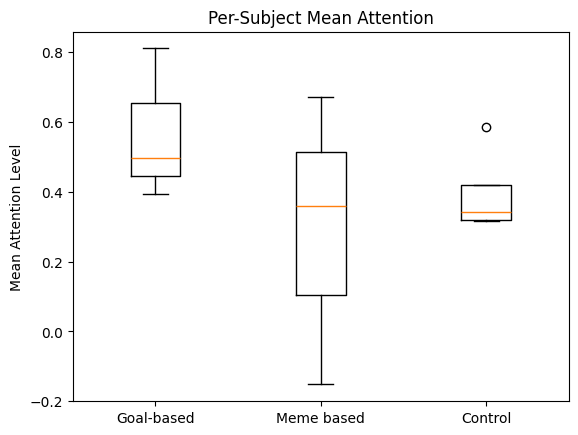

In [116]:
import matplotlib.pyplot as plt
plt.boxplot([group1_means, group2_means, group3_means], labels=["Goal-based", "Meme based", "Control"])
plt.ylabel("Mean Attention Level")
plt.title("Per-Subject Mean Attention")
plt.show()

In [141]:
for subject in parsed_data:
    df = pd.DataFrame.from_dict(parsed_data[subject]["pre"], orient='index').T
    df['read_moby_dick'] = df['read_moby_dick'].map({'Y': 7, 'N': 1})
    pre_numeric_cols = ['read_moby_dick', 'avid_reader', 'energy_level', "english_level", "dishes_procrastination", "deadline_extensions", "focus_on_difficult_material", "distracted_by_thoughts", "delayed_gratification", "motivation_to_be_well_read", "think_about_goals"]
    df[pre_numeric_cols] = df[pre_numeric_cols].apply(pd.to_numeric)
    df["group"] = subject.split("_")[-1]
    df["subject"] = " ".join(subject.split("_")[0].split("-"))
    parsed_data[subject]["pre_df"] = df

pre_dfs = [parsed_data[subject]["pre_df"] for subject in parsed_data]
pre_df_long = pre_df_long = pd.concat(pre_dfs, ignore_index=True)


# Melt wide to long
pre_long = pre_df_long.melt(
    id_vars=[],
    value_vars=pre_df_long.columns,
    var_name='question',
    value_name='answer'
)


for subject in parsed_data:
    df = pd.DataFrame.from_dict(parsed_data[subject]["post"], orient='index').T
    df['zoned_out'] = df['zoned_out'].map({'1': 7, '2': 1})
    df['use_tool_again'] = df['use_tool_again'].map({'1': 7, '2': 1})
    post_numeric_cols = ["engagement_level", "text_difficulty", "focus_level", "zoned_out", "mind_wandering_count", "attention_prompt_helpfulness", "personal_relevance", "use_tool_again"]
    df[post_numeric_cols] = df[post_numeric_cols].apply(pd.to_numeric)
    df["group"] = subject.split("_")[-1]
    df["subject"] = " ".join(subject.split("_")[0].split("-"))
    parsed_data[subject]["post_df"] = df

post_dfs = [parsed_data[subject]["post_df"] for subject in parsed_data]
post_df_long = post_df_long = pd.concat(post_dfs, ignore_index=True)

post_long = post_df_long.melt(
    id_vars=[],
    value_vars=post_df_long.columns,
    var_name='question',
    value_name='answer'
)


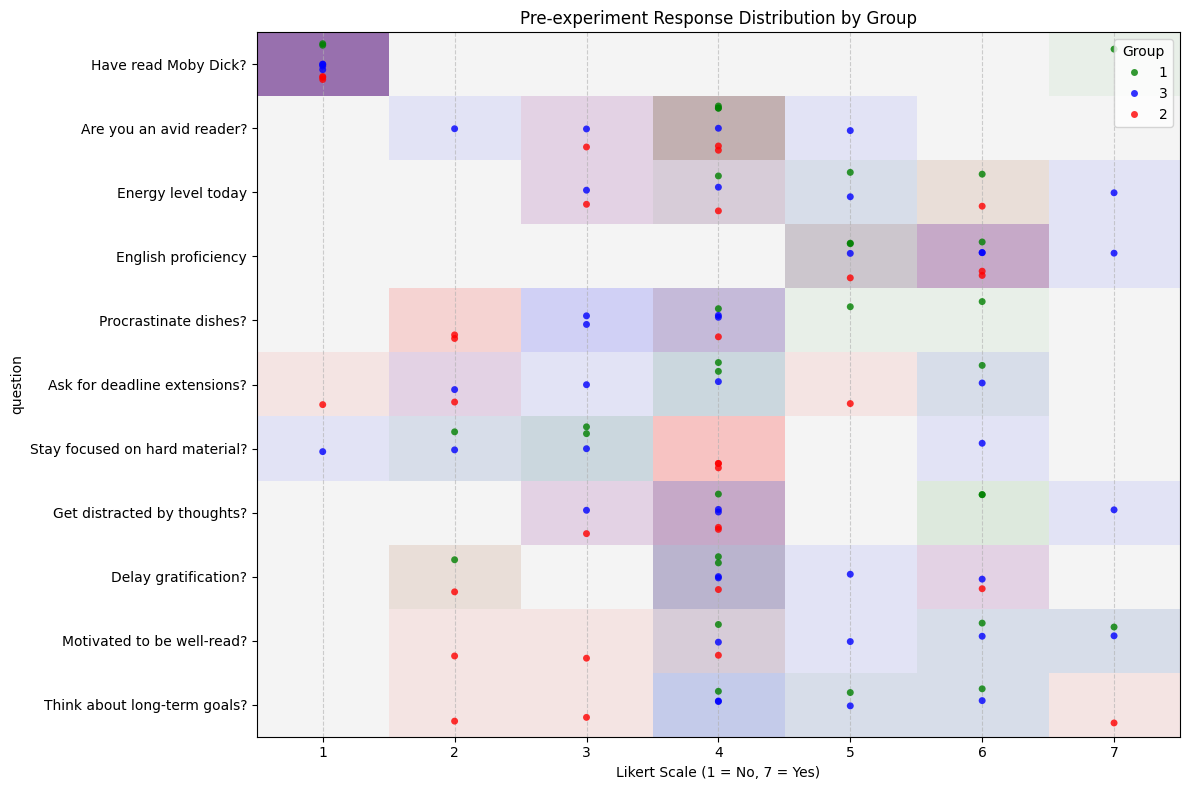

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pre_df_plot = pre_df_long[pre_numeric_cols + ['group']].copy()
pre_df_plot['group'] = pre_df_plot['group'].astype(str)
pre_df_plot = pre_df_plot.melt(id_vars='group', var_name='question', value_name='answer')

question_order = pre_df_plot['question'].unique()
question_to_idx = {q: i for i, q in enumerate(question_order)}
pre_df_plot['question_idx'] = pre_df_plot['question'].map(question_to_idx)
group_colors = {'1': 'green', '2': 'red', '3': 'blue'}
plt.figure(figsize=(12, 8))

for group in ['1', '2', '3']:
    sub = pre_df_plot[pre_df_plot['group'] == group]
    
    hist, xedges, yedges = np.histogram2d(
        sub['answer'], sub['question_idx'],
        bins=[np.arange(0.5, 8.5, 1), np.arange(-0.5, len(question_order)+0.5, 1)]
    )
    
    hist = hist / hist.max()  #

    plt.imshow(
        hist.T,
        extent=[0.5, 7.5, -0.5, len(question_order) - 0.5],
        aspect='auto',
        origin='lower',
        cmap=sns.light_palette(group_colors[group], as_cmap=True),
        alpha=0.3
    )
sns.stripplot(
    data=pre_df_plot,
    x='answer',
    y='question',
    hue='group',
    dodge=True,
    jitter=0.25,
    alpha=0.8,
    palette=group_colors
)

custom_labels = [
    "Have read Moby Dick?",
    "Are you an avid reader?",
    "Energy level today",
    "English proficiency",
    "Procrastinate dishes?",
    "Ask for deadline extensions?",
    "Stay focused on hard material?",
    "Get distracted by thoughts?",
    "Delay gratification?",
    "Motivated to be well-read?",
    "Think about long-term goals?"
]

plt.yticks(
    ticks=np.arange(len(question_order)), 
    labels=custom_labels
)

plt.xlabel('Likert Scale (1 = No, 7 = Yes)')
plt.title('Pre-experiment Response Distribution by Group')
plt.xlim(0.5, 7.5)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='Group')
plt.tight_layout()
plt.show()


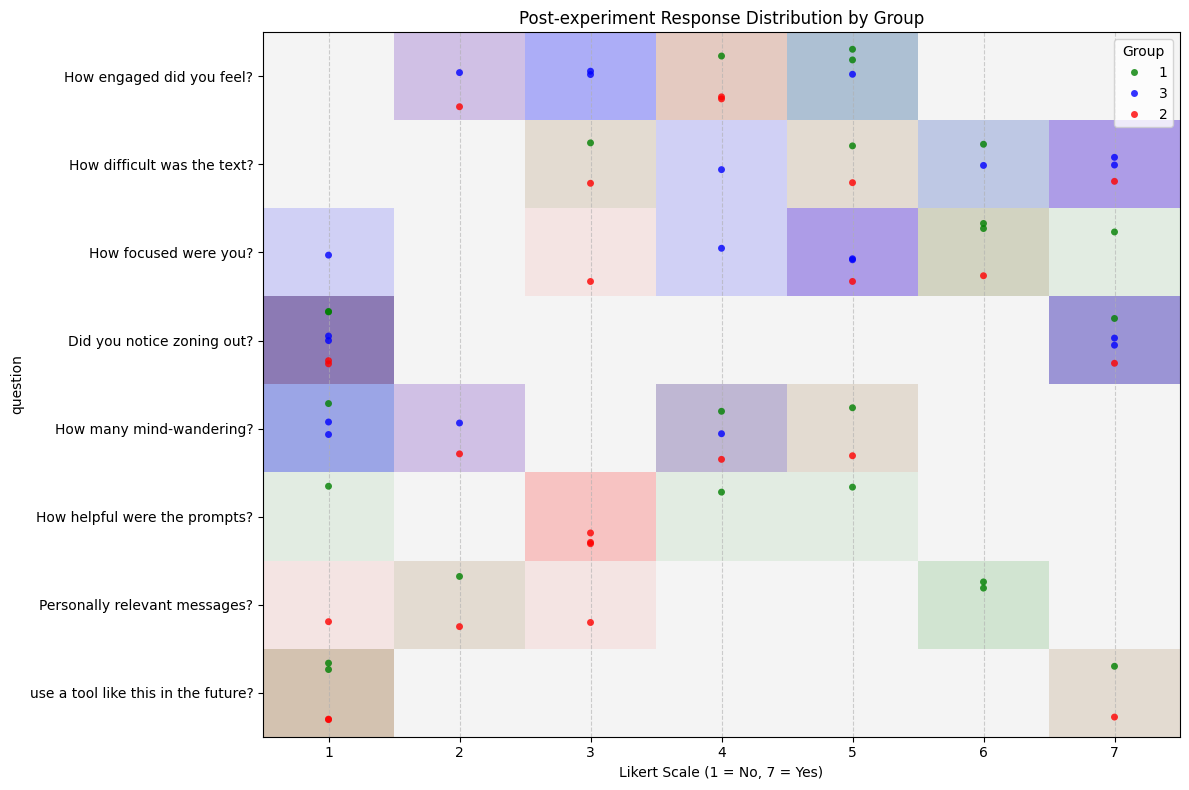

In [ ]:
post_df_plot = post_df_long[post_numeric_cols + ['group']].copy()
post_df_plot['group'] = post_df_plot['group'].astype(str)
post_df_plot = post_df_plot.melt(id_vars='group', var_name='question', value_name='answer')

question_order = post_df_plot['question'].unique()
question_to_idx = {q: i for i, q in enumerate(question_order)}
post_df_plot['question_idx'] = post_df_plot['question'].map(question_to_idx)

group_colors = {'1': 'green', '2': 'red', '3': 'blue'}

plt.figure(figsize=(12, 8))

for group in ['1', '2', '3']:
    sub = post_df_plot[post_df_plot['group'] == group]
    
    hist, xedges, yedges = np.histogram2d(
        sub['answer'], sub['question_idx'],
        bins=[np.arange(0.5, 8.5, 1), np.arange(-0.5, len(question_order)+0.5, 1)]
    )
    hist = hist / hist.max()  

    plt.imshow(
        hist.T,
        extent=[0.5, 7.5, -0.5, len(question_order) - 0.5],
        aspect='auto',
        origin='lower',
        cmap=sns.light_palette(group_colors[group], as_cmap=True),
        alpha=0.3
    )

sns.stripplot(
    data=post_df_plot,
    x='answer',
    y='question',
    hue='group',
    dodge=True,
    jitter=0.25,
    alpha=0.8,
    palette=group_colors
)

custom_labels = [
"How engaged did you feel?",
"How difficult was the text?",
"How focused were you?",
"Did you notice zoning out?",
"How many mind-wandering?",
"How helpful were the prompts?",
"Personally relevant messages?",
"use a tool like this in the future?",
]

plt.yticks(
    ticks=np.arange(len(question_order)),
    labels=custom_labels
)



plt.xlabel('Likert Scale (1 = No, 7 = Yes)')
plt.title('Post-experiment Response Distribution by Group')
plt.xlim(0.5, 7.5)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='Group')
plt.tight_layout()
plt.show()

In [145]:
for row in post_df_long[["additional_comments", "group", "subject"]].values:
    if row[1] != "3":
        print(row)

["System was too sensitive, it bothered me. I was wearing glasses, that could be the issue. Some parameters need be changed; text was hard to interpret, I had to re-read lines. It didn't feel personal enough these attention prompts, the system would need to get to know me better over a longer period of time. I liked the questionnaire a lot after the reading! better than the system itself."
 '1' 'A H']
['i didnt like it because the videos were not funny and if i read i want to read and dont want to see videos. the reading was very difficult.'
 '2' 'C H']
['It was annoying, that although I did pay attention, the program nudged me to continue. It disturbed my attention, because the videos made me laugh and actually took me longer to get back to the material.'
 '2' 'D H']
["in a third of the cases it was accurate, other times it was quite bothering. I became resentful and spiteful and I paid extra attention so that the system would not bother me as much. Sometimes even though I moved my ey